In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import random, shuffle
import itertools
from L_svd import L_svd
from numpy.fft import fft, ifft
from scipy.linalg import svd

# Generate the Graph

In [2]:
# make a fully connected graph
size = 40
nodes = [x for x in range(0, size)]
s = (size, size)
mCom = np.ones(s)
g = nx.Graph(mCom)

#mCom, nodes

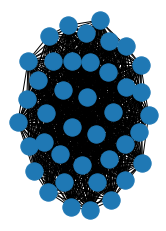

In [3]:
# look at it for fun
plt.subplot(121)
nx.draw(g)

In [4]:
# separate into 2 communities
shuffle(nodes)

first_community = nodes[:int(size/2)]
second_community = list(set(nodes) - set(first_community))

nodes, first_community, second_community

([4,
  24,
  2,
  14,
  8,
  5,
  19,
  20,
  11,
  16,
  30,
  15,
  29,
  10,
  1,
  7,
  25,
  39,
  36,
  12,
  21,
  3,
  35,
  28,
  34,
  13,
  31,
  23,
  38,
  26,
  6,
  9,
  37,
  22,
  32,
  0,
  33,
  17,
  27,
  18],
 [4, 24, 2, 14, 8, 5, 19, 20, 11, 16, 30, 15, 29, 10, 1, 7, 25, 39, 36, 12],
 [0, 3, 6, 9, 13, 17, 18, 21, 22, 23, 26, 27, 28, 31, 32, 33, 34, 35, 37, 38])

In [5]:
# going to use some python slickness here
connections = [i for i in itertools.combinations_with_replacement(nodes, 2)]

connections[:4]

[(4, 4), (4, 24), (4, 2), (4, 14)]

In [6]:
# remove "allowed connections"
first_community_connections = [i for i in itertools.permutations(first_community, 2)]
second_community_connections = [i for i in itertools.permutations(second_community, 2)]
loops = [(x,x) for x in range(0,size)]

connections = list(set(connections) - set(first_community_connections))
connections = list(set(connections) - set(loops))
illegal_connections = list(set(connections) - set(second_community_connections))

#illegal_connections

In [7]:
# choose a "link" that will be the final connection between the two communities before they would become separate
shuffle(illegal_connections)
link = illegal_connections.pop()
illegal_connections = list(set(illegal_connections) - set(link))

testMcom = mCom.copy()
link, testMcom.shape

((12, 22), (40, 40))

In [8]:
# for each of the remaining connections, remove it
results = np.zeros((size, len(illegal_connections), size))

for i, x in enumerate(illegal_connections, start=0):
    testMcom[x[0]][x[1]] = 0
    testMcom[x[1]][x[0]] = 0
    
    #print(results.shape)
    #print(testMcom.shape)
    
    results[:,i,:] = testMcom.copy()
    #print("counter: " + str(i))
    #print(testMcom)
    #print("~~")
    # print(results[:,i,:])
    #print("\/\/\/\/")
    #print(results[:,:,i])
    #print("____________________")

In [9]:
print(results[:,0,:])

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


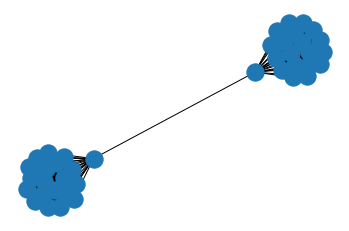

In [10]:
g_draw = nx.Graph(testMcom, with_labels=True, font_weight='bold')
plt.figure()
plt.plot()
nx.draw(g_draw)
plt.show()

In [11]:
t = np.array(results)

#
# First tricky part I run into is here... in the diagrams you drew for me, the shape
# of the adjacency matrix tensor is supposed to be 10, 24, 10 but here it is 24, 10, 10.
# When I reshape like such to account for this:
#
# a,b,c = t.shape
# t = t.reshape(b, a, c)
#
# Riley's SVD code takes a shit, something about incorrect sizing. So not sure it's 
# a problem but it doesn't seem right...

t.shape

(40, 399, 40)

# Some Useful Tensor Operations

The following were converted from the Matlab given to us at semester start or written as convenience functions for ease of debugging/understanding.

In [12]:
# to multiply two tensors
def t_prod(A, B):
    [a1 ,a2 ,a3] = A.shape
    [b1 ,b2 ,b3] = B.shape
    A = fft(A, axis = -1)
    B = fft(B, axis = -1)
    C = np.zeros((a1,b2,b3), dtype = complex)
    for i in np.arange(b3):
        C[:,:,i]=np.dot(A[:,:,i],B[:,:,i])
    C = ifft(C, axis = -1)
    return C

In [13]:
# tensor circulant
def t_circ(A):
    n, m, p = A.shape
    res = np.zeros((n*p, m*p))
    
    res[:, 0:m] = unfold(A)
    
    for j in range(1, p):
        first_thing = res[(p-1)*n:p*n, (j-1)*m:(j)*m]
        second_thing = res[0:(p-1)*n, (j-1)*m:j*m]
        the_thing = np.concatenate((first_thing, second_thing), axis=0)
        res[:, j*m:(j+1)*m] = the_thing
    
    return res

In [14]:
# tensor unfold
def unfold(A):
    n, m, p = A.shape
    v_res = np.zeros((n*p, m))
    
    for i in range(0, p):
        temp = A[:,:,i]
        v_res[i*n:(i+1)*n,0:m] = A[:,:,i]
    
    return v_res

In [15]:
# tensor fold up
def fold_up(A, n1, n2, n3):
    
    knt = 0
    res = np.zeros((n1,n2,n3))
    
    for i in range(0, int(n3)):
        #print(knt, knt+n1, 0, n2)
        res[:,:,i] = A[knt:knt+n1, 0:n2]
        knt += n1
        
    return res

In [16]:
# tensor transpose
def t_tran(A):
    ten_circ = t_circ(A)
    #print(ten_circ.shape)
    ten_circ = ten_circ.transpose()
    #print(ten_circ.shape)
    n2,n1,n3 = A.shape
    #print(n1,n2,n3)
    res = fold_up(ten_circ, n1, n2, n3)
    return res 

In [17]:
def printFrontalSlices(A):
    _, _, p = A.shape
    rep = "\n"
    for i in range(0,p):
        vals = A[:,:,i:i+1].reshape(2,2)
        rep += str(vals)
        rep += "\n"
        
    return rep

In [18]:
def t_svd(A, k = None):
    n1, n2, n3 = A.shape
    
    trans_flag = False
    print(A.shape)
    
    # transpose and swap if wrong shape
    if(n2 > n1):
        trans_flag = True
        A = t_tran(A)
        swap = n1
        n1 = n2
        n2 = swap
        
    A = fft(A, axis=2)
    
    # flag to compute compact or full
    fl = 1
    if k is not None:
        fl = 0
    
    K = min(n1, n2)
    
    if (fl == 0):
        U = np.zeros((n1, n1, n3))
        S = np.zeros((K, K, n3))
        V = np.zeros((K, n2, n3))
    else:
        U = np.zeros((n1, n1, n3))
        S = np.zeros((n2, n2, n3))
        V = np.zeros((n2, n2, n3))
    
    for i in range(0, n3):
        if (fl == 0):
            U1, S1, V1 = svd(A[:,:,i], full_matrices = True)
            U[:,:,i] = U1
            S_mat = np.diag(S1.tolist())
            S[:,:,i] = S_mat
            V[:,:,i] = np.flip(V1)
        else:
            U1, S1, V1 = svd(A[:,:,i])
            U[:,:,i] = U1
            S_mat = np.diag(S1.tolist())
            S[:,:,i] = S_mat
            V[:,:,i] = np.flip(V1)
            
    if trans_flag:
        Uold = U
        U = V
        S = t_tran(S)
        V = Uold
    
    return np.real(ifft(U, axis=2)), np.real(ifft(S, axis=2)), np.real(ifft(V, axis=2))

# Decomposition

In [19]:
U, S, V = t_svd(t)

(40, 399, 40)


/home/tim/Documents/research/env/lib/python3.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tim/Documents/research/env/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part


In [20]:
U.shape, S.shape, V.shape

((40, 40, 40), (40, 40, 40), (399, 399, 40))

In [25]:
Mt = t_prod(t_tran(U[:,0:2,:]), t)

Mt.shape

(2, 399, 40)

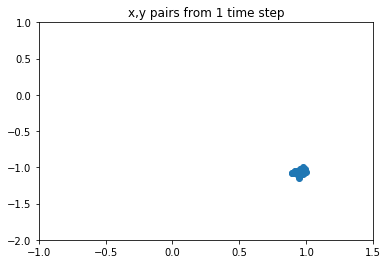

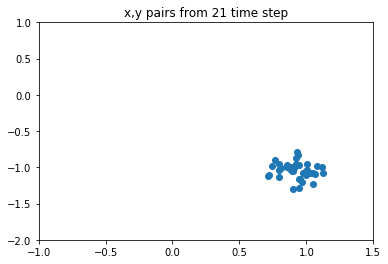

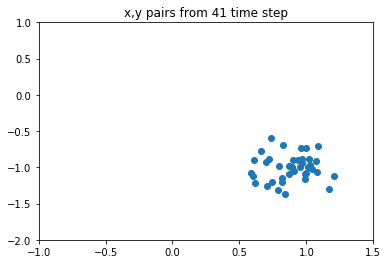

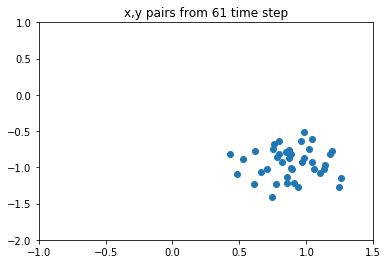

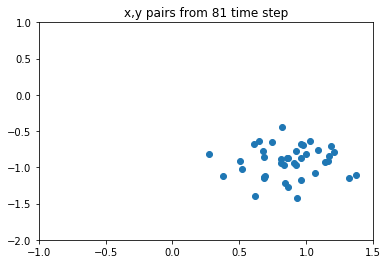

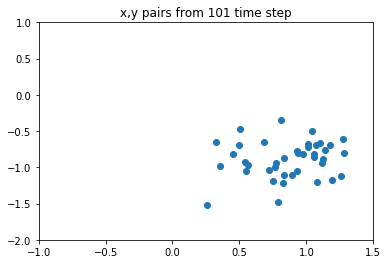

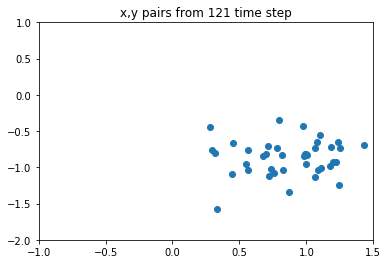

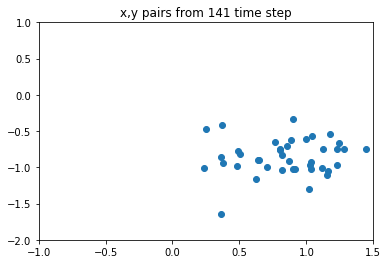

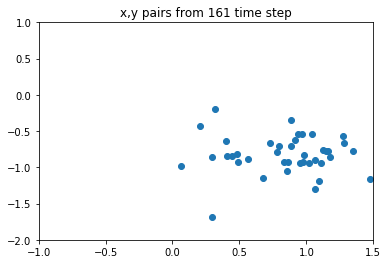

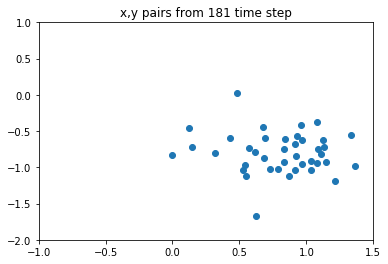

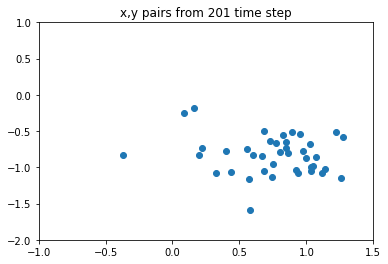

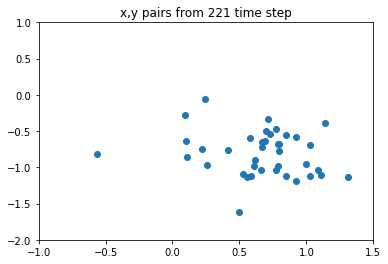

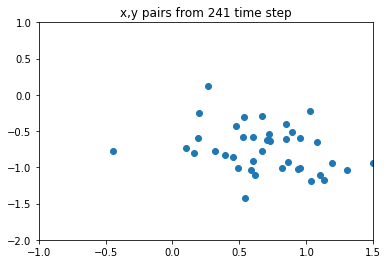

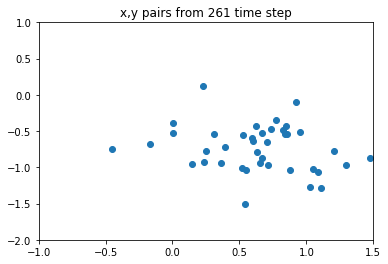

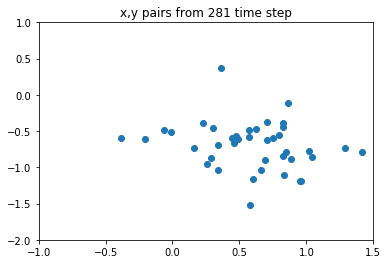

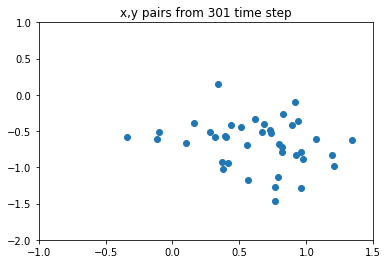

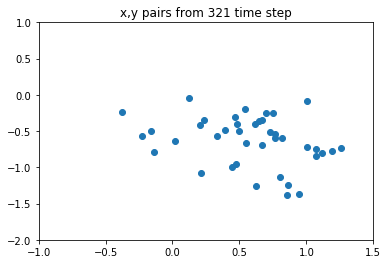

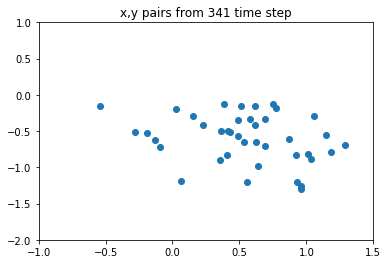

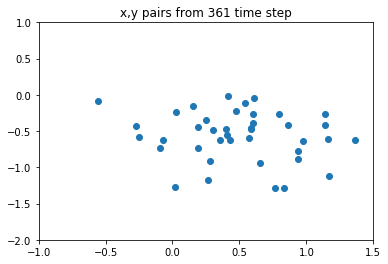

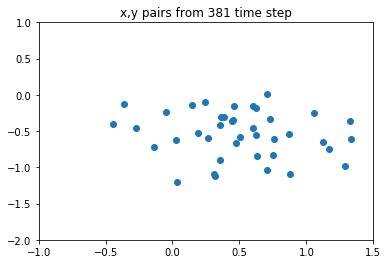

In [27]:

_, steps, _ = Mt.shape

for i in range(0, steps, 20):
    G = np.squeeze(Mt[:,i,:])
    #print(G.shape)
    plt.scatter(G[0,:], G[1,:])
    plt.ylim(-2, 1)
    plt.xlim(-1, 1.5)
    plt.title("x,y pairs from {} time step".format(i+1))
    plt.savefig("{}step.png".format(i))
    plt.show()